<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/0903EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset exploration**

In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[1]


'PaperedControl21v_light.tif'

In [4]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [5]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [6]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

filename category
0    PaperedControl21d.tif   marked
1    PaperedControl22v.tif   marked
2    PaperedControl22d.tif   marked
3    PaperedControl23v.tif   marked
4    PaperedControl23d.tif   marked
..                     ...      ...
752  PaperedControl19v.tif   marked
753  PaperedControl19d.tif   marked
754  PaperedControl20v.tif   marked
755  PaperedControl20d.tif   marked
756  PaperedControl21v.tif   marked

[757 rows x 2 columns]

In [7]:
dfmark=df[df['category']=='marked']
dfmark

filename category
0    PaperedControl21d.tif   marked
1    PaperedControl22v.tif   marked
2    PaperedControl22d.tif   marked
3    PaperedControl23v.tif   marked
4    PaperedControl23d.tif   marked
..                     ...      ...
752  PaperedControl19v.tif   marked
753  PaperedControl19d.tif   marked
754  PaperedControl20v.tif   marked
755  PaperedControl20d.tif   marked
756  PaperedControl21v.tif   marked

[479 rows x 2 columns]

In [8]:
dfunmark=df[df['category']=='unmarked']
dfunmark

filename  category
336  NoPaperedGreen20v.tif  unmarked
337  NoPaperedGreen20d.tif  unmarked
338  NoPaperedGreen38v.tif  unmarked
339  NoPaperedGreen38d.tif  unmarked
340  NoPaperedGreen26v.tif  unmarked
..                     ...       ...
732   NoPaperedGreen8v.tif  unmarked
733   NoPaperedGreen9v.tif  unmarked
734   NoPaperedGreen9d.tif  unmarked
735  NoPaperedGreen10v.tif  unmarked
736  NoPaperedGreen10d.tif  unmarked

[278 rows x 2 columns]

In [9]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

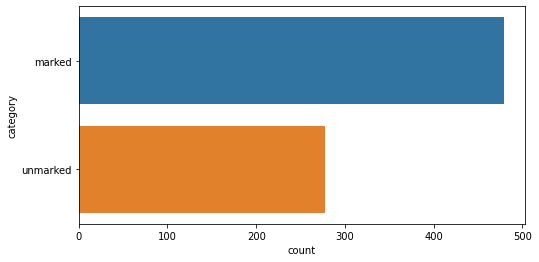

In [10]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[1]))
image.shape

(1944, 2592, 3)

In [ ]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df.sample(9)
tmp_df

filename  category
651        PaperedMixed33d.tif    marked
386      NoPaperedGreen39v.tif  unmarked
686       NoPaperedMixed1d.tif  unmarked
71       PaperedControl56d.tif    marked
41       PaperedControl41d.tif    marked
521      NoPaperedMixed18d.tif  unmarked
166  PaperedTransparent25v.tif    marked
589         PaperedMixed2d.tif    marked
91       PaperedControl66v.tif    marked

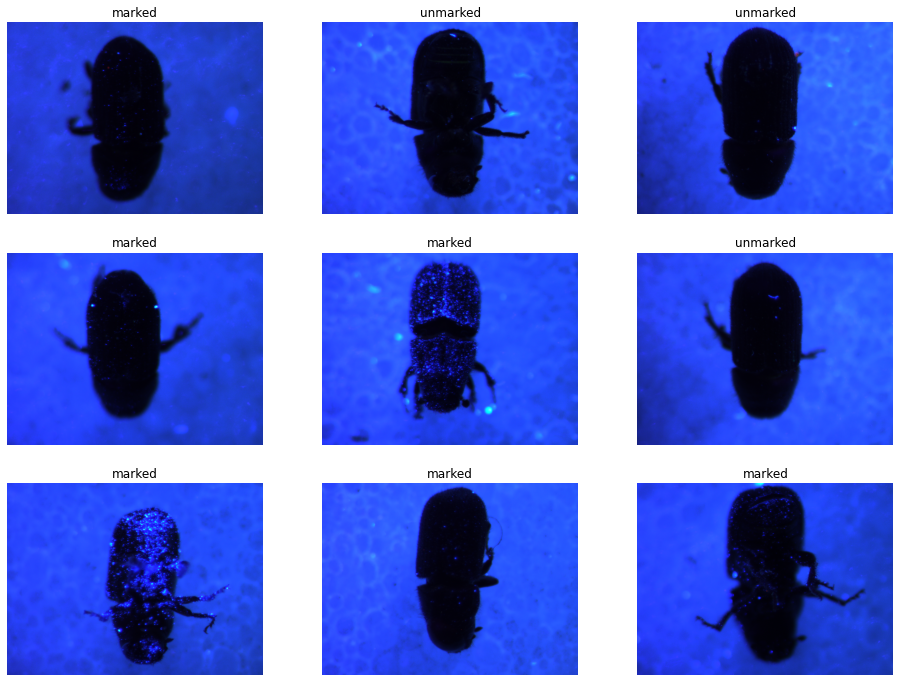

In [ ]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

**Traininng and validation set**

In [ ]:
train_df1, validate_df1 = train_test_split(dfmark, test_size = 0.2, random_state = 42, stratify = dfmark['category'])
train_df1 = train_df1.reset_index(drop=True)
validate_df1 = validate_df1.reset_index(drop=True)

In [ ]:
train_df2, validate_df2 = train_test_split(dfunmark, test_size = 0.2, random_state = 42, stratify = dfunmark['category'])
train_df2 = train_df2.reset_index(drop=True)
validate_df2 = validate_df2.reset_index(drop=True)

In [ ]:
train_df=train_df1.append(train_df2)
train_df

filename  category
0    PaperedTransparent105d.tif    marked
1         PaperedControl68d.tif    marked
2         PaperedControl34d.tif    marked
3     PaperedTransparent27d.tif    marked
4     PaperedTransparent84v.tif    marked
..                          ...       ...
217       NoPaperedGreen59v.tif  unmarked
218       NoPaperedMixed32v.tif  unmarked
219       NoPaperedGreen45d.tif  unmarked
220       NoPaperedGreen23d.tif  unmarked
221        NoPaperedGreen9v.tif  unmarked

[605 rows x 2 columns]

In [ ]:
validate_df=validate_df1.append(validate_df2)
validate_df

filename  category
0   PaperedTransparent22v.tif    marked
1   PaperedTransparent88d.tif    marked
2   PaperedTransparent97d.tif    marked
3         PaperedMixed24d.tif    marked
4   PaperedTransparent42d.tif    marked
..                        ...       ...
51      NoPaperedGreen76v.tif  unmarked
52      NoPaperedGreen85d.tif  unmarked
53      NoPaperedGreen16d.tif  unmarked
54       NoPaperedMixed7v.tif  unmarked
55      NoPaperedMixed11d.tif  unmarked

[152 rows x 2 columns]

**Traininng and validation set (Random)**

In [68]:
train_df, validate_df = train_test_split(df, test_size = 0.33, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

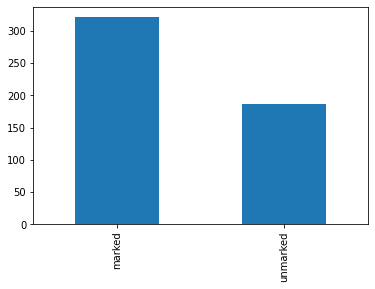

In [69]:
train_df['category'].value_counts().plot.bar()

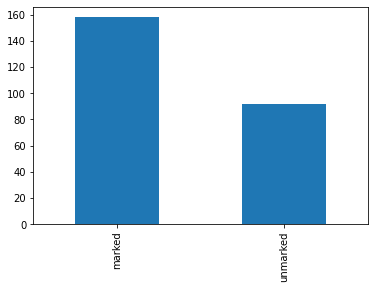

In [70]:
validate_df['category'].value_counts().plot.bar()

In [74]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32

In [75]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [76]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [77]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 507 validated image filenames belonging to 2 classes.


In [78]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 250 validated image filenames belonging to 2 classes.


**Build the model**

In [79]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB5,resnet50,EfficientNetB7
def create_model():
  base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3),classes=2)
        # Freeze the pretrained weights resnet50.ResNet50
  base.trainable = False
  #for layer in base.layers[:-40]:  # Training just part of the architecture do not optimize the performance
      #layer.trainable = False
  model = Sequential()
  model.add(base)
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(BatchNormalization())
  #model.add(Flatten())
  model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 19, 19, 2560)      64097687  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2560)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2560)              10240     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               655616    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [80]:
EPOCHS = 20
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [81]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Mymodel/0903EnetB7_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [82]:
results = Model_fit()

Epoch 1/20
15/15 [==============================] - 460s 29s/step - loss: 1.0380 - accuracy: 0.6632 - val_loss: 0.4838 - val_accuracy: 0.7277


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
15/15 [==============================] - 417s 28s/step - loss: 0.6952 - accuracy: 0.8105 - val_loss: 0.5355 - val_accuracy: 0.6607
Epoch 3/20
15/15 [==============================] - 412s 28s/step - loss: 0.7592 - accuracy: 0.7747 - val_loss: 0.4177 - val_accuracy: 0.7545
Epoch 4/20
15/15 [==============================] - 410s 28s/step - loss: 0.6478 - accuracy: 0.8358 - val_loss: 0.3826 - val_accuracy: 0.8839
Epoch 5/20
15/15 [==============================] - 421s 28s/step - loss: 0.8429 - accuracy: 0.8084 - val_loss: 0.4332 - val_accuracy: 0.7411
Epoch 6/20
15/15 [==============================] - 423s 29s/step - loss: 0.7220 - accuracy: 0.7937 - val_loss: 0.3702 - val_accuracy: 0.8214
Epoch 7/20
15/15 [==============================] - 415s 28s/step - loss: 0.8332 - accuracy: 0.7937 - val_loss: 0.3673 - val_accuracy: 0.8527
Epoch 8/20
15/15 [==============================] - 425s 29s/step - loss: 0.6012 - accuracy: 0.8063 - val_loss: 0.3582 - val_accuracy: 0.8438
Epoch 

In [83]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.890526294708252
Val_Cat-Acc:  0.9330357313156128


In [84]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("EfficientNetB7'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [85]:
import keras

final_model = keras.models.load_model('/content/drive/MyDrive/Mymodel/0903EnetB7_model.h5')

**Testing on random 10 samples**

In [86]:
tmp_df1=df.sample(10)
tmp_df1

filename  category
59       PaperedControl50v.tif    marked
346      NoPaperedGreen15v.tif  unmarked
756      PaperedControl21v.tif    marked
301  PaperedTransparent92d.tif    marked
751      PaperedControl18d.tif    marked
173  PaperedTransparent28d.tif    marked
441      NoPaperedGreen63d.tif  unmarked
543      NoPaperedMixed29d.tif  unmarked
754      PaperedControl20v.tif    marked
731       NoPaperedGreen8d.tif  unmarked

In [87]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
tmp_df1["prediction"]=preds

In [88]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

filename  category prediction
59       PaperedControl50v.tif    marked   unmarked
346      NoPaperedGreen15v.tif  unmarked     marked
756      PaperedControl21v.tif    marked     marked
301  PaperedTransparent92d.tif    marked     marked
751      PaperedControl18d.tif    marked     marked
173  PaperedTransparent28d.tif    marked     marked
441      NoPaperedGreen63d.tif  unmarked     marked
543      NoPaperedMixed29d.tif  unmarked     marked
754      PaperedControl20v.tif    marked     marked
731       NoPaperedGreen8d.tif  unmarked     marked

**Testing on training set**

In [89]:
nb_samples1 = train_df.shape[0]

In [90]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator = test_gen.flow_from_dataframe(
     train_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 507 validated image filenames.


In [91]:
predictdf = final_model.predict(test_generator, steps=np.ceil(nb_samples1/BATCH_SIZE))

In [92]:
train_df['prediction'] = np.argmax(predictdf, axis=-1)
train_df["prediction"] = train_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
train_df

filename  category prediction
0           PaperedMixed9v.tif    marked     marked
1        PaperedControl40d.tif    marked     marked
2         NoPaperedGreen5v.tif  unmarked   unmarked
3        PaperedControl18v.tif    marked     marked
4        NoPaperedGreen78d.tif  unmarked     marked
..                         ...       ...        ...
502      NoPaperedMixed41d.tif  unmarked   unmarked
503      PaperedControl29v.tif    marked     marked
504  PaperedTransparent47v.tif    marked     marked
505        PaperedMixed46d.tif    marked     marked
506        PaperedMixed47d.tif    marked     marked

[507 rows x 3 columns]

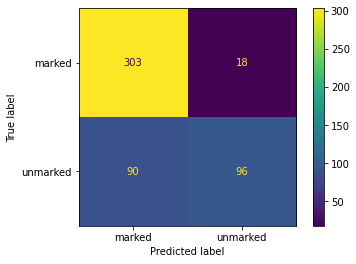

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(train_df['category'])
y_pred=list(train_df['prediction'])
cm1=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

**Testing on validation set**

In [94]:
to_samples = validate_df.shape[0]

In [95]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 250 validated image filenames.


In [96]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))
predict

array([[4.50739354e-01, 5.49260676e-01],
       [9.99513984e-01, 4.85978293e-04],
       [9.71415162e-01, 2.85848118e-02],
       [4.65580910e-01, 5.34419119e-01],
       [7.09054917e-02, 9.29094553e-01],
       [6.50086880e-01, 3.49913150e-01],
       [6.72524154e-01, 3.27475846e-01],
       [9.93946493e-01, 6.05349196e-03],
       [7.04590678e-01, 2.95409322e-01],
       [9.98905540e-01, 1.09443511e-03],
       [5.80687523e-01, 4.19312477e-01],
       [3.79932344e-01, 6.20067656e-01],
       [3.64483476e-01, 6.35516465e-01],
       [7.21161425e-01, 2.78838575e-01],
       [9.93965328e-01, 6.03469787e-03],
       [8.06145430e-01, 1.93854585e-01],
       [6.72043920e-01, 3.27956080e-01],
       [4.38613147e-01, 5.61386883e-01],
       [9.44495678e-01, 5.55044040e-02],
       [9.46656168e-01, 5.33438213e-02],
       [8.96786392e-01, 1.03213646e-01],
       [8.30527604e-01, 1.69472367e-01],
       [6.88848734e-01, 3.11151236e-01],
       [5.77631235e-01, 4.22368735e-01],
       [9.909787

In [97]:
validate_df['prediction'] = np.argmax(predict, axis=1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

filename  category prediction
0        NoPaperedGreen72d.tif  unmarked   unmarked
1        PaperedControl48v.tif    marked     marked
2    PaperedTransparent57v.tif    marked     marked
3        NoPaperedGreen10v.tif  unmarked   unmarked
4        NoPaperedGreen57v.tif  unmarked   unmarked
..                         ...       ...        ...
245      NoPaperedGreen22d.tif  unmarked     marked
246        PaperedMixed14v.tif    marked     marked
247  PaperedTransparent75d.tif    marked     marked
248  PaperedTransparent37d.tif    marked   unmarked
249        PaperedMixed25d.tif    marked     marked

[250 rows x 3 columns]

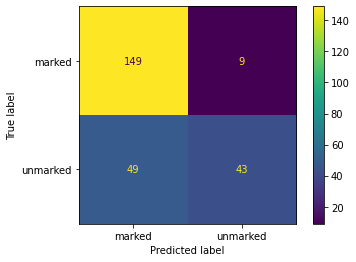

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

In [99]:
to_samples2 = df.shape[0]

In [100]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    #rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    #width_shift_range = 0.2,
                    #height_shift_range = 0.2,
                    #shear_range = 0.2,
                    #zoom_range = 0.2,
                    #horizontal_flip = True,
                    #vertical_flip = True,
                    #fill_mode = 'nearest'
                    )
test_generator1 = test_gen.flow_from_dataframe(
    df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 757 validated image filenames.


In [101]:
predict2 = final_model.predict(test_generator1, steps=np.ceil(to_samples2/BATCH_SIZE))
predict2

array([[0.99439335, 0.0056066 ],
       [0.9444957 , 0.0555044 ],
       [0.9749808 , 0.02501925],
       ...,
       [0.99809915, 0.00190088],
       [0.99602026, 0.00397973],
       [0.9939465 , 0.00605348]], dtype=float32)

In [102]:
df['prediction'] = np.argmax(predict2, axis=1)
df["prediction"] = df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
df

filename category prediction
0    PaperedControl21d.tif   marked     marked
1    PaperedControl22v.tif   marked     marked
2    PaperedControl22d.tif   marked     marked
3    PaperedControl23v.tif   marked     marked
4    PaperedControl23d.tif   marked     marked
..                     ...      ...        ...
752  PaperedControl19v.tif   marked     marked
753  PaperedControl19d.tif   marked     marked
754  PaperedControl20v.tif   marked     marked
755  PaperedControl20d.tif   marked     marked
756  PaperedControl21v.tif   marked     marked

[757 rows x 3 columns]

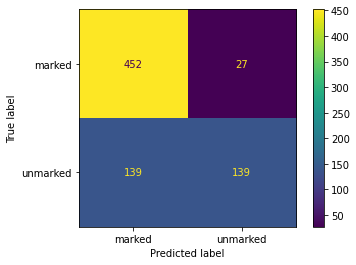

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(df['category'])
y_pred=list(df['prediction'])
cm2=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

**Random things**

In [ ]:
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,horizontal_flip=True)
def pred(dataframe):
    for image_id in dataframe.filename:
        img = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=BATCH_SIZE)
        yhats = final_model.predict(it, steps=np.ceil(1/BATCH_SIZE), verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(df)

In [ ]:
predictions

0

In [ ]:
preds=[]
for image_id in df.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
df["prediction"]=preds

In [ ]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

filename  category prediction
594       NoPaperedMixed35v.tif  unmarked     marked
405       NoPaperedGreen22v.tif  unmarked   unmarked
655         PaperedMixed15d.tif    marked     marked
34        PaperedControl33d.tif    marked     marked
708         PaperedMixed42d.tif    marked     marked
363  PaperedTransparent104v.tif    marked     marked
516       NoPaperedGreen82v.tif  unmarked   unmarked
323   PaperedTransparent84v.tif    marked     marked
266   PaperedTransparent57v.tif    marked     marked
478       NoPaperedGreen62v.tif  unmarked   unmarked